In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from pathlib import Path
from utils import OptimalFeatures, build_classifier, result_summary_table, plot_classwise_performance_bar
from utils import plot_feature_importance, create_venn_diagram, compare_models_classification
import warnings
warnings.filterwarnings('ignore')


plt.style.use('seaborn-v0_8')
%matplotlib inline 

In [2]:
data_dir = f"{Path.cwd().parent.parent}/data"
opt_ftrs = OptimalFeatures()
filtered_series_matrix = pd.read_csv(f'{data_dir}/filtered_expression_matrix.csv')

sample_labels = pd.read_csv(f'{data_dir}/GSE120584_sample_labels.csv')

In [3]:
filtered_series_matrix.head()

,ID_REF,GSM3403761,GSM3403762,GSM3403763,GSM3403764,GSM3403765,GSM3403766,GSM3403767,GSM3403768,GSM3403769,...,GSM3405352,GSM3405353,GSM3405354,GSM3405355,GSM3405356,GSM3405357,GSM3405358,GSM3405359,GSM3405360,GSM3405361
0,MIMAT0000245,3.247633,3.322302,3.832967,3.099451,3.972978,4.319297,3.272810,2.834856,3.627556,...,4.417478,3.757778,4.574933,4.837825,4.416106,2.755368,3.247889,4.054153,3.463225,4.143556
1,MIMAT0005588,4.666568,4.239831,3.841522,4.553042,4.213964,4.319297,3.707037,4.075516,3.751721,...,4.274165,5.065757,4.614088,4.197017,4.395825,4.321873,4.677839,4.697839,4.651253,4.746008
2,MIMAT0005905,6.424362,5.908149,5.786100,6.202725,6.438405,6.197940,5.694039,6.273598,5.853613,...,4.911331,6.116618,6.584719,6.654529,5.865405,7.085877,6.681850,7.013891,6.715800,7.207587
3,MIMAT0007349,4.314688,4.202207,3.974663,4.258664,4.458520,4.319297,3.877794,4.471617,4.458999,...,4.302670,4.304476,5.247297,4.563546,5.235158,4.856806,4.574527,4.858040,4.695997,5.076922
4,MIMAT0007401,4.302577,3.655424,3.967952,3.724011,3.179096,4.319297,3.670145,3.502049,3.607003,...,4.123010,4.035980,4.282634,4.197017,4.352998,2.321851,4.004131,4.048914,3.743187,4.901239


In [4]:
X = filtered_series_matrix.set_index('ID_REF').transpose()
y = np.array([sample_labels[sample_labels['Sample ID'] == sample_id]['LABEL'] for sample_id in filtered_series_matrix.columns[1:]]).flatten()

In [5]:
X.shape, y.shape

((1601, 30), (1601,))

In [6]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Label encoding:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"  {class_name} --- {i}")

Label encoding:
  AD --- 0
  DLB --- 1
  MCI --- 2
  NC --- 3
  VaD --- 4


In [7]:
opt_ftrs.get_df()

,ranking_method,classifier,optimal_features,best_mcc,optimal_feature_names
0,mRMR,RF,29,0.916929,"['MIMAT0027423', 'MIMAT0027468', 'MIMAT0016889..."
1,mRMR,DT,28,0.643162,"['MIMAT0027423', 'MIMAT0027468', 'MIMAT0016889..."
2,MCFS,RF,26,0.921822,"['MIMAT0027575', 'MIMAT0014984', 'MIMAT0027512..."
3,MCFS,DT,27,0.649763,"['MIMAT0027575', 'MIMAT0014984', 'MIMAT0027512..."


In [8]:
opt_ftrs.get_ftr_names('mRMR','RF')

['MIMAT0027423',
 'MIMAT0027468',
 'MIMAT0016889',
 'MIMAT0014984',
 'MIMAT0027455',
 'MIMAT0027512',
 'MIMAT0022731',
 'MIMAT0015064',
 'MIMAT0007349',
 'MIMAT0026474',
 'MIMAT0019893',
 'MIMAT0027575',
 'MIMAT0027583',
 'MIMAT0018004',
 'MIMAT0019743',
 'MIMAT0005588',
 'MIMAT0019858',
 'MIMAT0027559',
 'MIMAT0027650',
 'MIMAT0022491',
 'MIMAT0005905',
 'MIMAT0027404',
 'MIMAT0026477',
 'MIMAT0000245',
 'MIMAT0027565',
 'MIMAT0027488',
 'MIMAT0012735',
 'MIMAT0007401',
 'MIMAT0016849']

In [9]:
len(opt_ftrs.get_ftr_names('MCFS','RF'))

26

In [10]:
optimal_mrmr_features = opt_ftrs.get_ftr_names('mRMR','RF')
optimal_mcfs_features = opt_ftrs.get_ftr_names('MCFS','RF')

In [11]:
final_classifiers = {}

# mRMR -- RF -- SMOTE
final_classifiers['mrmr_rf_smote'] = build_classifier(
    X, y_encoded, opt_ftrs.get_ftr_names('mRMR','RF'), label_encoder, 'RF', True
)

# mRMR -- DT -- SMOTE
final_classifiers['mrmr_dt_smote'] = build_classifier(
    X, y_encoded, opt_ftrs.get_ftr_names('mRMR','DT'), label_encoder, 'DT', True
)

# MCFS -- RF -- SMOTE
final_classifiers['mcfs_rf_smote'] = build_classifier(
    X, y_encoded, opt_ftrs.get_ftr_names('MCFS','RF'), label_encoder, 'RF', True)

# MCFS -- DT -- SMOTE
final_classifiers['mcfs_dt_smote'] = build_classifier(
    X, y_encoded, opt_ftrs.get_ftr_names('MCFS','DT'), label_encoder, 'DT', True
)

RF:
Accuracy: 0.9328 (+/- 0.0164)
Ftrs: 29
DT:
Accuracy: 0.5350 (+/- 0.0263)
Ftrs: 28
RF:
Accuracy: 0.9369 (+/- 0.0105)
Ftrs: 26
DT:
Accuracy: 0.5120 (+/- 0.0299)
Ftrs: 27


In [12]:
# mRMR -- RF -- NO SMOTE
final_classifiers['mrmr_rf_no_smote'] = build_classifier(
    X, y_encoded, opt_ftrs.get_ftr_names('mRMR','RF'), label_encoder, 'RF', False
)

# mRMR -- DT -- NO SMOTE
final_classifiers['mrmr_dt_no_smote'] = build_classifier(
    X, y_encoded, opt_ftrs.get_ftr_names('mRMR','DT'), label_encoder, 'DT', False
)

# MCFS -- RF -- NO SMOTE
final_classifiers['mcfs_rf_no_smote'] = build_classifier(
    X, y_encoded, opt_ftrs.get_ftr_names('MCFS','RF'), label_encoder, 'RF', False)

# MCFS -- DT -- NO SMOTE
final_classifiers['mcfs_dt_no_smote'] = build_classifier(
    X, y_encoded, opt_ftrs.get_ftr_names('MCFS','DT'), label_encoder, 'DT', False
)

RF:
Accuracy: 0.6933 (+/- 0.0414)
Ftrs: 29
DT:
Accuracy: 0.6427 (+/- 0.0344)
Ftrs: 28
RF:
Accuracy: 0.6895 (+/- 0.0408)
Ftrs: 26
DT:
Accuracy: 0.6465 (+/- 0.0346)
Ftrs: 27


In [13]:
final_classifiers['mrmr_rf_smote']['classification_report']

{'AD': {'precision': 0.9105691056910569,
  'recall': 0.7678746327130265,
  'f1-score': 0.8331562167906482,
  'support': 1021.0},
 'DLB': {'precision': 0.9008189262966333,
  'recall': 0.9696376101860921,
  'f1-score': 0.9339622641509434,
  'support': 1021.0},
 'MCI': {'precision': 0.9816602316602316,
  'recall': 0.9960822722820764,
  'f1-score': 0.988818667963053,
  'support': 1021.0},
 'NC': {'precision': 0.9030754892823858,
  'recall': 0.9490695396669931,
  'f1-score': 0.9255014326647565,
  'support': 1021.0},
 'VaD': {'precision': 0.9671814671814671,
  'recall': 0.9813907933398629,
  'f1-score': 0.9742343218279047,
  'support': 1021.0},
 'accuracy': 0.9328109696376102,
 'macro avg': {'precision': 0.9326610440223548,
  'recall': 0.9328109696376101,
  'f1-score': 0.9311345806794611,
  'support': 5105.0},
 'weighted avg': {'precision': 0.932661044022355,
  'recall': 0.9328109696376102,
  'f1-score': 0.9311345806794613,
  'support': 5105.0}}

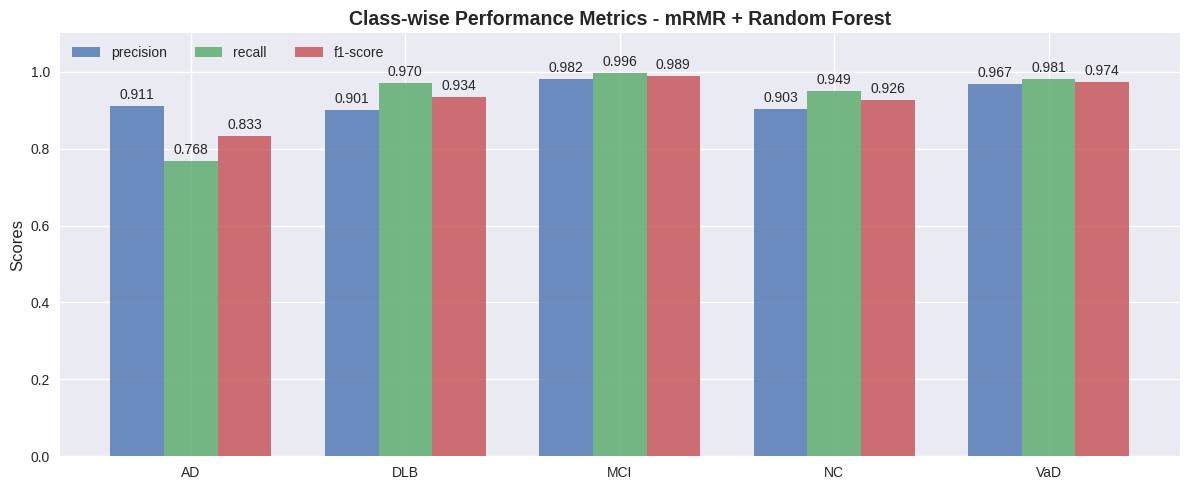

In [14]:
plot_classwise_performance_bar(final_classifiers['mrmr_rf_smote']['classification_report'], "mRMR + Random Forest")

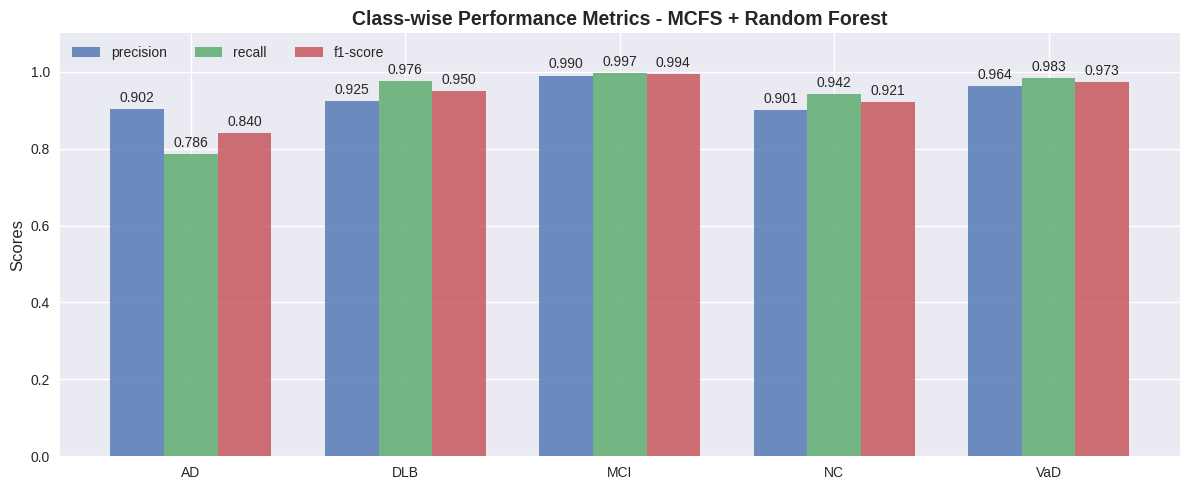

In [20]:
plot_classwise_performance_bar(final_classifiers['mcfs_rf_smote']['classification_report'], "MCFS + Random Forest")

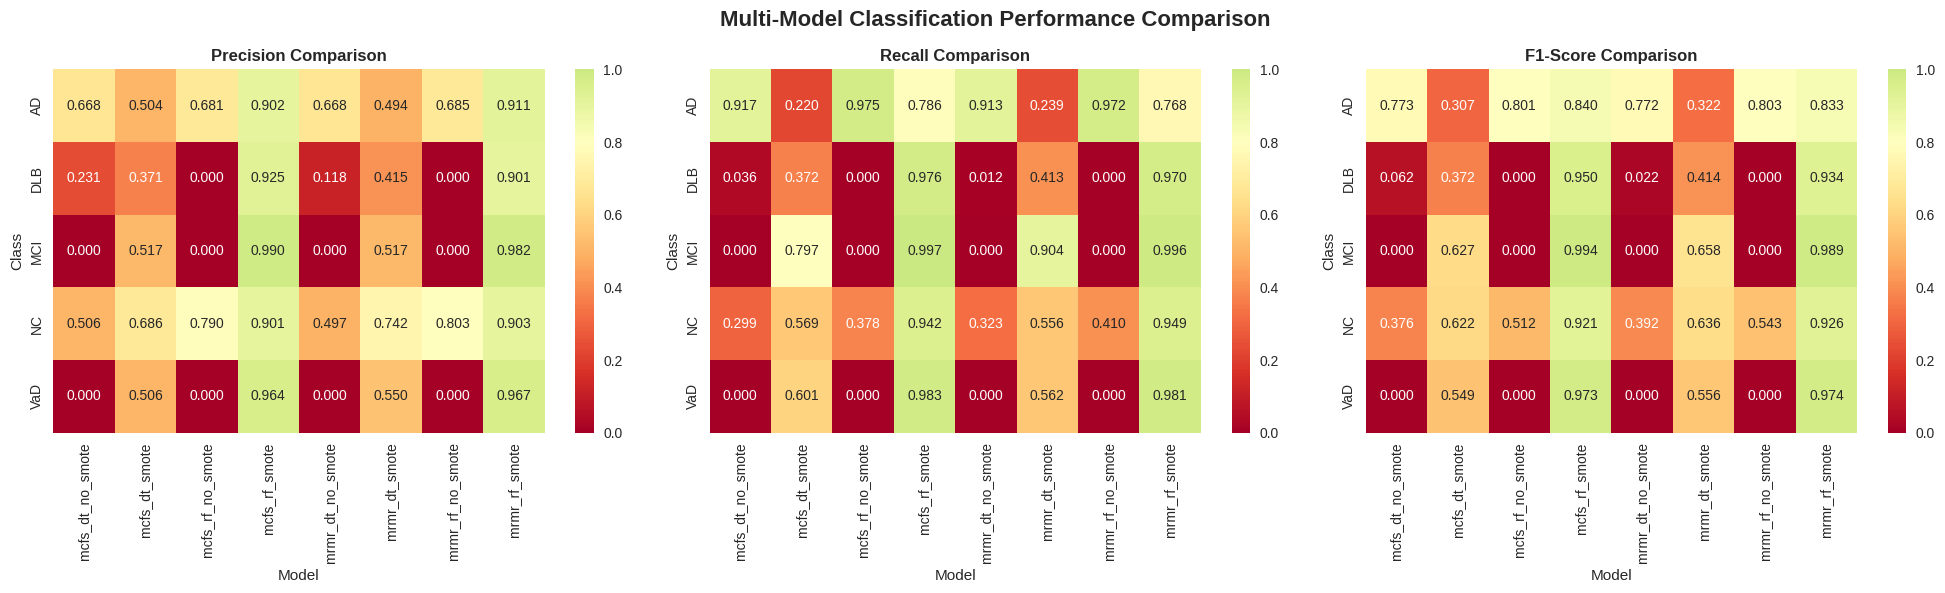

In [15]:
comparison_df = compare_models_classification(final_classifiers)

In [16]:
styled_table = result_summary_table(final_classifiers)
styled_table

,Model,Accuracy,F1-score(weighted),MCC
0,mRMR + RF + SMOTE,0.9328,0.9311,0.9169
1,mRMR + DT + SMOTE,0.5350,0.5172,0.4289
2,MCFS + RF + SMOTE,0.9369,0.9356,0.9218
3,MCFS + DT + SMOTE,0.5120,0.4954,0.3995
4,mRMR + RF + (NO SMOTE),0.6933,0.6098,0.3222
5,mRMR + DT + (NO SMOTE),0.6415,0.5647,0.1850
6,MCFS + RF + (NO SMOTE),0.6896,0.6032,0.3113
7,MCFS + DT + (NO SMOTE),0.6421,0.5670,0.1945


In [17]:
def get_optimal_feature_subsets(): 
    mrmr_optimal_features = opt_ftrs.get_ftr_names('mRMR','RF')
    mcfs_optimal_features = opt_ftrs.get_ftr_names('MCFS','RF') 
    common_features = set(mrmr_optimal_features) & set(mcfs_optimal_features)  
    return mrmr_optimal_features, mcfs_optimal_features, common_features
 
mrmr_optimal, mcfs_optimal, common = get_optimal_feature_subsets()

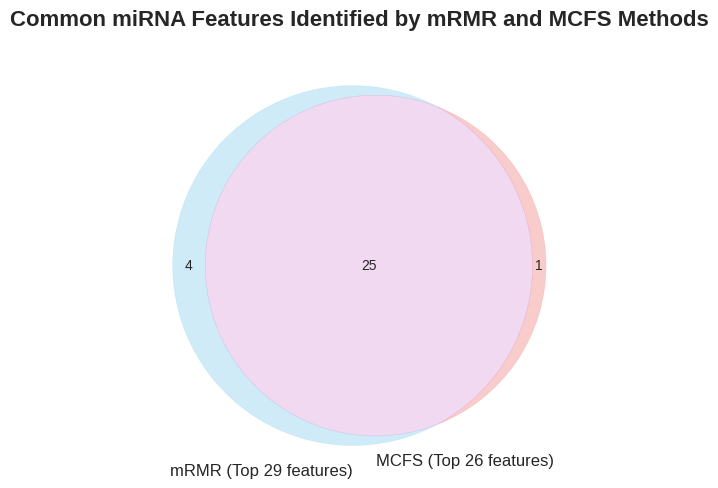

In [18]:
mrmr_only, mcfs_only = create_venn_diagram(mrmr_optimal, mcfs_optimal, common)

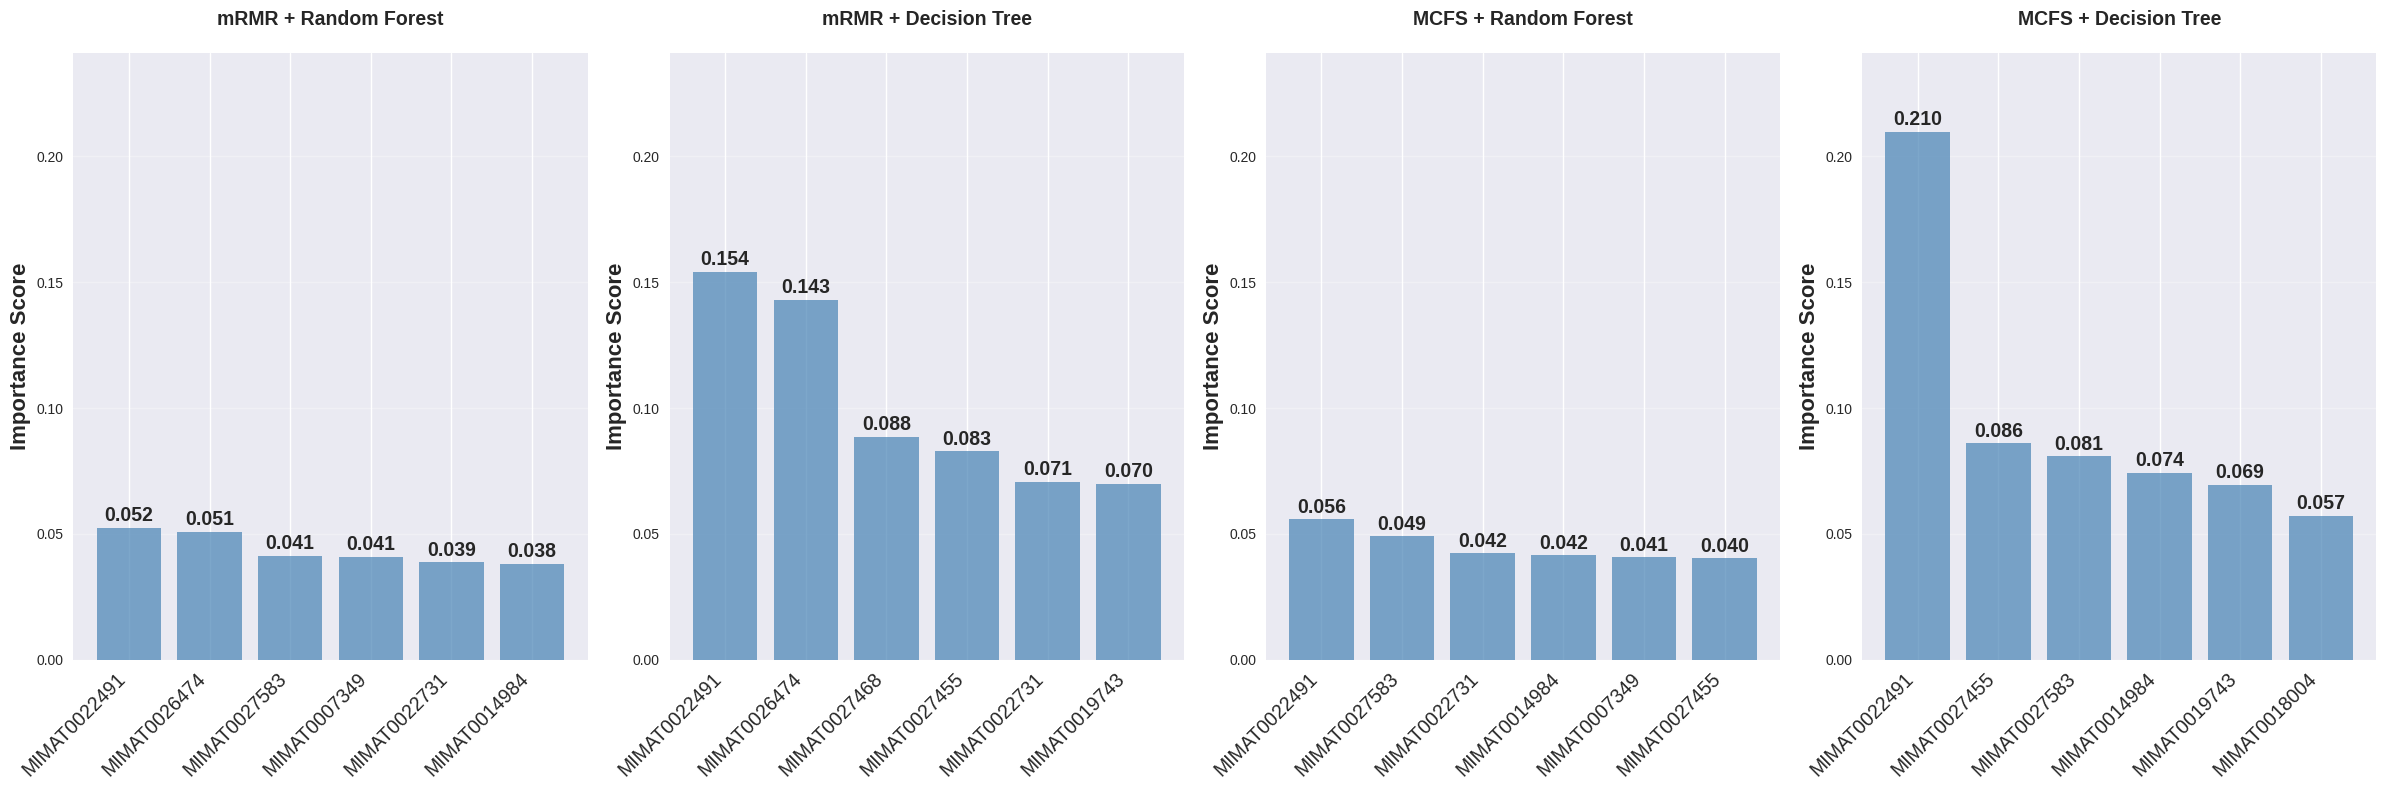

In [19]:
plot_feature_importance(final_classifiers)